## Students Adaptability Level in Online Education

### 데이터 로드 및 전처리

In [240]:
import pandas as pd

URL = "http://suanlab.com/datasets/students_adaptability_level_online_education.csv"
df = pd.read_csv(URL)

df

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
1201,Girl,16-20,College,Non Government,No,No,High,Mid,Wifi,4G,3-6,No,Mobile,Moderate
1202,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate
1203,Girl,16-20,College,Non Government,No,No,Low,Mid,Wifi,4G,1-3,No,Mobile,Low


In [241]:
from sklearn.model_selection import train_test_split

target = 'Adaptivity Level'
x = df.drop(columns=[target])
y = df[target]

train_data, test_data, train_label, test_label = train_test_split(x, y, test_size=.2)
train = pd.concat((train_data, train_label), axis=1)
test = pd.concat((test_data, test_label), axis=1)

print(f"Train data: {train.shape}")
print(f"Test data: {test.shape}")

Train data: (964, 14)
Test data: (241, 14)


In [242]:
train

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
1131,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
392,Girl,16-20,College,Non Government,No,No,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
842,Girl,11-15,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,1-3,No,Mobile,Low
1001,Girl,16-20,College,Non Government,No,No,High,Mid,Wifi,4G,3-6,No,Mobile,Moderate
184,Girl,16-20,College,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate
576,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Low
345,Boy,21-25,University,Non Government,Yes,No,High,Poor,Mobile Data,3G,1-3,Yes,Mobile,Moderate
729,Girl,1-5,School,Non Government,No,Yes,Low,Poor,Mobile Data,4G,1-3,No,Mobile,Moderate


In [243]:
ordinal_cols = ["Age", "Education Level", "Load-shedding", 'Financial Condition', 'Network Type', 'Adaptivity Level']
nominal_cols = train.columns.difference(ordinal_cols)

In [244]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 964 entries, 1131 to 918
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               964 non-null    object
 1   Age                  964 non-null    object
 2   Education Level      964 non-null    object
 3   Institution Type     964 non-null    object
 4   IT Student           964 non-null    object
 5   Location             964 non-null    object
 6   Load-shedding        964 non-null    object
 7   Financial Condition  964 non-null    object
 8   Internet Type        964 non-null    object
 9   Network Type         964 non-null    object
 10  Class Duration       964 non-null    object
 11  Self Lms             964 non-null    object
 12  Device               964 non-null    object
 13  Adaptivity Level     964 non-null    object
dtypes: object(14)
memory usage: 113.0+ KB


In [245]:
for col in ordinal_cols:
    print(f"{col}: {train[col].unique()}")

Age: ['16-20' '11-15' '21-25' '26-30' '1-5' '6-10']
Education Level: ['College' 'School' 'University']
Load-shedding: ['Low' 'High']
Financial Condition: ['Mid' 'Poor' 'Rich']
Network Type: ['4G' '3G' '2G']
Adaptivity Level: ['Low' 'Moderate' 'High']


In [246]:
from sklearn.preprocessing import OrdinalEncoder

orders = {
    'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
    'Education Level': ['School', 'College', 'University' ],
    'Load-shedding': ['Low', 'High'],
    'Financial Condition': ['Poor', 'Mid', 'Rich'],
    'Network Type': ['2G', '3G', '4G' ],
    'Adaptivity Level': ['Low', 'Moderate', 'High']
}

oe = OrdinalEncoder(categories=list(orders.values()))
train[ordinal_cols] = oe.fit_transform(train[ordinal_cols])
test[ordinal_cols] = oe.transform(test[ordinal_cols])

In [247]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
train_ohe = ohe.fit_transform(train[nominal_cols]).toarray()
test_ohe = ohe.transform(test[nominal_cols]).toarray()

train_ohe_df = pd.DataFrame(train_ohe, columns=ohe.get_feature_names_out(nominal_cols), index=train.index)
test_ohe_df = pd.DataFrame(test_ohe, columns=ohe.get_feature_names_out(nominal_cols), index=test.index)

In [248]:
from keras.utils import to_categorical

train_preprocessed = pd.concat((train[ordinal_cols], train_ohe_df), axis=1).sort_index()
test_preprocessed = pd.concat((test[ordinal_cols], test_ohe_df), axis=1).sort_index()

x_train = train_preprocessed.drop(columns=[target])
x_test = test_preprocessed.drop(columns=[target])
y_train = to_categorical(train_preprocessed[target])
y_test = to_categorical(test_preprocessed[target])

### 모델 구성 및 컴파일

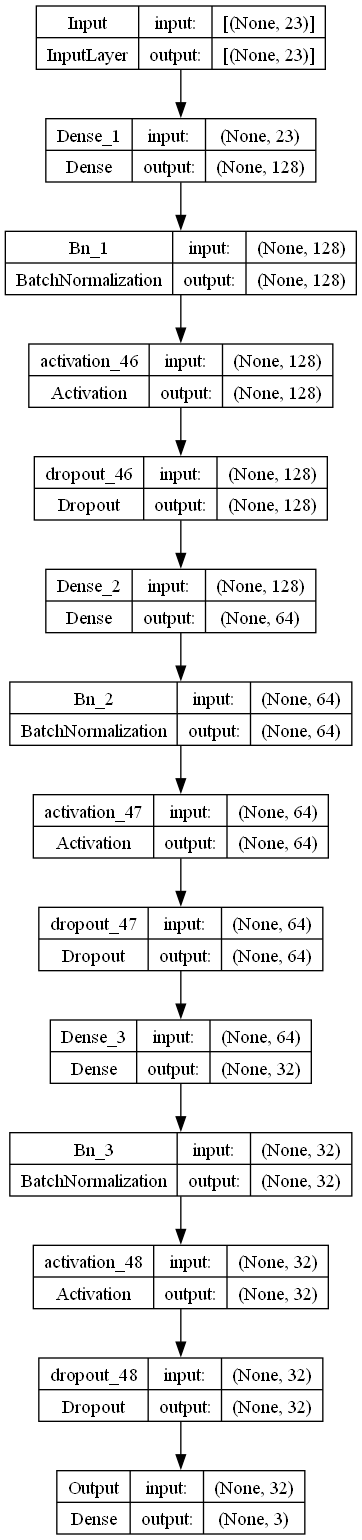

In [249]:
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras.utils import plot_model

inp = Input(shape=(len(x_train.columns), ), name="Input")
dense_1 = Dense(128, kernel_initializer='he_normal', name="Dense_1")(inp)
bn_1 = BatchNormalization(name="Bn_1")(dense_1)
act_1 = Activation('relu')(bn_1)
dropout_1 = Dropout(0.5)(act_1)
dense_2 = Dense(64, kernel_initializer='he_normal', name="Dense_2")(dropout_1)
bn_2 = BatchNormalization(name="Bn_2")(dense_2)
act_2 = Activation('relu')(bn_2)
dropout_2 = Dropout(0.5)(act_2)
dense_3 = Dense(32, kernel_initializer='he_normal', name="Dense_3")(dropout_2)
bn_3 = BatchNormalization(name="Bn_3")(dense_3)
act_3 = Activation('relu')(bn_3)
dropout_3 = Dropout(0.5)(act_3)
out = Dense(3, activation='softmax', name='Output')(dropout_3)

model = Model(inputs=inp, outputs=out)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

plot_model(model, show_shapes=True)

### 모델 학습

In [250]:
from keras.callbacks import EarlyStopping

early_stop_cb = EarlyStopping(
    patience=100,
    monitor='val_loss',
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=4000,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop_cb]
)

Epoch 1/4000
2/2 [==============================] - 2s 283ms/step - loss: 1.3165 - accuracy: 0.3658 - val_loss: 0.9186 - val_accuracy: 0.4508
Epoch 2/4000
2/2 [==============================] - 0s 39ms/step - loss: 1.3421 - accuracy: 0.3671 - val_loss: 0.9115 - val_accuracy: 0.4508
Epoch 3/4000
2/2 [==============================] - 0s 41ms/step - loss: 1.3473 - accuracy: 0.3735 - val_loss: 0.9072 - val_accuracy: 0.4819
Epoch 4/4000
2/2 [==============================] - 0s 39ms/step - loss: 1.2673 - accuracy: 0.4047 - val_loss: 0.9036 - val_accuracy: 0.5181
Epoch 5/4000
2/2 [==============================] - 0s 38ms/step - loss: 1.2345 - accuracy: 0.4202 - val_loss: 0.9019 - val_accuracy: 0.5337
Epoch 6/4000
2/2 [==============================] - 0s 34ms/step - loss: 1.2818 - accuracy: 0.4202 - val_loss: 0.9023 - val_accuracy: 0.5285
Epoch 7/4000
2/2 [==============================] - 0s 34ms/step - loss: 1.2232 - accuracy: 0.4099 - val_loss: 0.9032 - val_accuracy: 0.5492
Epoch 8/4000

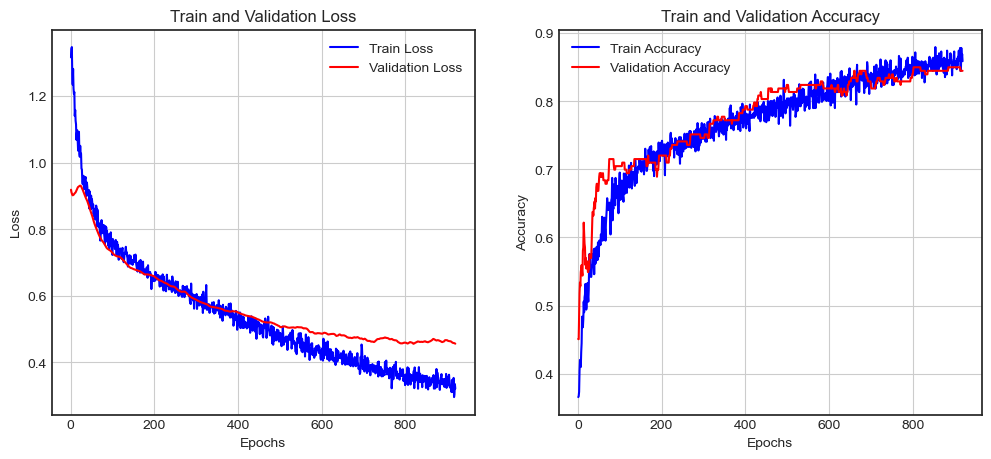

In [251]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

fig = plt.figure(figsize=(12, 5))

ax_1 = fig.add_subplot(1, 2, 1)

ax_1.plot(epochs, loss, 'b', label='Train Loss')
ax_1.plot(epochs, val_loss, 'r', label='Validation Loss')

ax_1.set_title("Train and Validation Loss")
ax_1.set_xlabel("Epochs")
ax_1.set_ylabel('Loss')
ax_1.grid()
ax_1.legend()

ax_2 = fig.add_subplot(1, 2, 2)

ax_2.plot(epochs, accuracy, 'b', label='Train Accuracy')
ax_2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

ax_2.set_title("Train and Validation Accuracy")
ax_2.set_xlabel("Epochs")
ax_2.set_ylabel('Accuracy')
ax_2.grid()
ax_2.legend()

plt.show()

### 모델 평가 및 예측

In [252]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.3693 - accuracy: 0.8548


[0.36930713057518005, 0.8547717928886414]